In [1]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset

torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [2]:
# 数据增强
train_tfm = transforms.Compose([
    # 中心裁剪
    transforms.Resize((112, 112)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    # 随机水平翻转和垂直翻转
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    # 亮度颜色调整
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# 创建一个变换对象，随机对图像进行中心裁剪
transform_center_crop = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# 在测试集中不需要做过多的调整
test_tfm = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [25]:
# 通过datasetfolder从文件夹中加载数据，在通过dataloader创建数据迭代器
batch_size = 64


def fillcrop(img):  # 把第一次裁剪的图片填充为正方形，避免resize时会改变比例
    img = np.array(img)

    # 以最长的一边为边长，把短的边补为一样长，做成正方形，避免resize时会改变大脑的比例
    down = img.shape[0]  # 行数
    up = img.shape[1]  # 列数
    max1 = max(down, up)  # 比较行数和列数哪个大，来决定以谁作为正方形的边长
    down = (max1 - down) // 2  # 整除，大的值必然为0，而小的需要补上相应的值。比方说down更大，则赋值以后down为0，表示行不需要填充像素点
    up = (max1 - up) // 2
    down_zuo, down_you = down, down
    up_zuo, up_you = up, up

    if (max1 - img.shape[0]) % 2 != 0:  # 考虑奇数的情况，若为奇数则需要在行的左边多加一列
        down_zuo = down_zuo + 1
    if (max1 - img.shape[1]) % 2 != 0:
        up_zuo = up_zuo + 1
    matrix_pad = np.pad(img, pad_width=((down_zuo, down_you),  # 向上填充1个维度，向下填充两个维度
                                        (up_zuo, up_you)),  # 向左填充2个维度，向右填充一个维度
                        mode="constant",  # 填充模式
                        constant_values=(0, 0))  # 第一个维度（就是向上和向左）填充6，第二个维度（向下和向右）填充5
    return matrix_pad


def precrop(image_data):  # 初次裁剪大脑
    scaled_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255
    img = np.uint8(scaled_data)

    index = np.where(img > 50)  # 找出像素值大于50的所以像素值的坐标，也就是获取表示大脑部分的像素的索引
    x = index[0]  # 获取所有表示大脑部分的像素的横坐标
    y = index[1]  # 获取所有表示大脑部分的像素的纵坐标
    max_x = max(x)  # 横坐标的最大值表示有边界，其余同理
    min_x = min(x)
    max_y = max(y)
    min_y = min(y)
    max_x = max_x + 10  # +10是为了多裁剪一部分黑色的区域，防止可以有部分边缘的大脑未被裁剪
    min_x = min_x - 10
    max_y = max_y + 10
    min_y = min_y - 10
    if max_x > img.shape[0]:
        max_x = img.shape[0]
    if min_x < 0:
        min_x = 0
    if max_y > img.shape[1]:
        max_y = img.shape[1]
    if min_y < 0:
        min_y = 0
    img = img[min_x:max_x, min_y:max_y]
    return fillcrop(img)


def load_image(filepath):
    with open(filepath, 'rb') as f:
        img = Image.open(f)
        # 将图片转化为numpy数组
        img = np.array(img)
        img = img.astype(np.float32)
        # 对这个numpy数组进行裁剪填充等操作
        img = precrop(img)
        # 将这个数组在转为图片，并将其转为rgb模式（升维）
        return Image.fromarray(img).convert('RGB')


# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
path = './PETjpg/'
train_set = DatasetFolder(path + "train", loader=load_image, extensions="jpg",
                          transform=train_tfm)
valid_set = DatasetFolder(path + "val", loader=load_image, extensions="jpg",
                          transform=test_tfm)
test_set = DatasetFolder(path + "test", loader=load_image, extensions="jpg",
                         transform=test_tfm)

train_set1 = DatasetFolder(path + "train", loader=load_image, extensions="jpg",
                           transform=test_tfm)
train_set2 = DatasetFolder(path + "train", loader=load_image, extensions="jpg",
                           transform=transform_center_crop)

concat_dataset = ConcatDataset([train_set, train_set1, train_set2])
# Construct data loaders.
train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)

In [32]:
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()

        model = models.resnet34(True)
        model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512, 2)
        )
        self.resnet = model

    def forward(self, img):
        out = self.resnet(img)
        return out

In [33]:
class mydataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index]
        # Apply transformations if given.
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target


pseudo = []


def get_pseudo_labels(dataset, model, threshold=0.8):
    #这个函数使用给定的模型生成数据集的伪标签。
    #它返回一个DatasetFolder实例，其中包含预测置信度超过给定阈值的图像。
    # 存储当前每个样本的置信度
    cur_pseudo = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # 将模型切换为评估模式
    model.eval()
    # 在最后一个维度上进行softmax
    softmax = nn.Softmax(dim=-1)
    unlabeled_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
    new_data = []
    # Iterate over the dataset by batches.
    for batch in tqdm(unlabeled_loader):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        # 通过对logits应用softmax得到概率分布
        probs = softmax(logits)
        # ---------- TODO ----------
        # 如果预测概率超过阈值，则将图像和标签添加到新数据集中
        for i in range(len(probs)):
            label, prob = torch.argmax(probs[i]), torch.max(probs[i])
            cur_pseudo.append(float(prob))
            if prob > threshold:
                new_data.append((img[i], int(label)))
        # Filter the data and construct a new dataset.
    new_dataset = mydataset(new_data)
    print("新数据集已经筛选完成，共筛选出", len(new_dataset), "个未打标签的样本加入训练")
    pseudo.append(cur_pseudo)
    # 将模型切换为训练模式
    model.train()
    return new_dataset

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Initialize a model, and put it on the device specified.

model = XunFeiNet().to(device)
model.device = device

# 加载之前训练好的模型参数
weights_path = None
if weights_path:
    state_dict = torch.load(weights_path)
    model.load_state_dict(state_dict)


# 自定义的带标签平滑的损失函数
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        # 此处的self.smoothing即我们的epsilon平滑参数。

    def forward(self, x, target):
        # 此处x的shape应该是(batch size * class数量)，所以这里在class数量那个维度做了logsoftmax。
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        # 此处的target的shape是(batch size), 应该就是每个training data的数字标签。
        # 这里unsqueeze之后，就是(batch size * 1 )
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        # 把输出的shape变回(batch size)
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


# For the classification task, we use cross-entropy as the measurement of performance.
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothing()
criterion1 = nn.MSELoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
n_epoch = 30
# 是否要进行半监督学习
do_semi = False

In [35]:
def one_hot_encode(labels, num_classes):
    one_hot_labels = torch.zeros(labels.size(0), num_classes)
    # 使用scatter函数进行one-hot编码
    one_hot_labels.scatter_(1, labels.view(-1, 1), 1)
    return one_hot_labels


total_train_loss = []
total_val_loss = []
total_train_loss1 = []
total_val_loss1 = []

total_train_acc = []
total_val_acc = []

# 最小的验证集loss
min_val_loss = -1000

In [36]:
def train(n_epochs=n_epoch):
    global train_loader, valid_loader, min_val_loss
    for epoch in range(n_epochs):
        # 当开始进行半监督时，将min_val_loss重置
        if epoch == n_epochs / 2 and do_semi:
            min_val_loss = -1000
        # 在每个epoch中，为半监督学习重新标记未标记的数据集。
        # 然后你可以将标记数据集和伪标记数据集结合起来进行训练。
        if epoch > (n_epochs / 2) and do_semi:
            # 使用训练模型获取未标记数据的伪标签。
            pseudo_set = get_pseudo_labels(test_set, model)
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                                      pin_memory=True)

        model.train()

        train_loss = []
        train_loss1 = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):
            imgs, labels = batch
            logits = model(imgs.to(device))
            loss = criterion(logits, labels.to(device))
            loss1 = criterion1(logits, one_hot_encode(labels, 2).to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            train_loss.append(loss.item())
            train_loss1.append((loss1.item()))
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_loss1 = sum(train_loss1) / len(train_loss1)
        train_acc = sum(train_accs) / len(train_accs)

        total_train_loss.append(float(train_loss))
        total_train_loss1.append(float(train_loss1))
        total_train_acc.append(float(train_acc))
        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_loss1 = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in valid_loader:
            imgs, labels = batch
            with torch.no_grad():
                logits = model(imgs.to(device))
            loss = criterion(logits, labels.to(device))
            loss1 = criterion1(logits, one_hot_encode(labels, 2).to(device))
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            valid_loss.append(loss.item())
            valid_loss1.append((loss1.item()))
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_loss1 = sum(valid_loss1) / len(valid_loss1)
        valid_acc = sum(valid_accs) / len(valid_accs)

        total_val_loss.append(float(valid_loss))
        total_val_loss1.append((float(valid_loss1)))
        total_val_acc.append(float(valid_acc))
        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # save the model:
        model_score = valid_loss * -0.5 + valid_acc * 0.8
        if model_score > min_val_loss:
            min_val_loss = model_score
            torch.save(model.state_dict(), './weight/{}loss_{:.3f}_acc_{:.3f}.pth'.format(epoch, valid_loss, valid_acc))

In [37]:
train(30)

  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 001/030 ] loss = 0.53239, acc = 0.75805
[ Valid | 001/030 ] loss = 0.63874, acc = 0.69940


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 002/030 ] loss = 0.40365, acc = 0.86742
[ Valid | 002/030 ] loss = 0.71336, acc = 0.76637


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 003/030 ] loss = 0.35309, acc = 0.90120
[ Valid | 003/030 ] loss = 0.66430, acc = 0.67783


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 004/030 ] loss = 0.31708, acc = 0.92919
[ Valid | 004/030 ] loss = 0.65456, acc = 0.73065


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 005/030 ] loss = 0.30436, acc = 0.93604
[ Valid | 005/030 ] loss = 0.68457, acc = 0.76116


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 006/030 ] loss = 0.28882, acc = 0.94487
[ Valid | 006/030 ] loss = 0.69454, acc = 0.77753


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 007/030 ] loss = 0.27923, acc = 0.95404
[ Valid | 007/030 ] loss = 0.79414, acc = 0.67560


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 008/030 ] loss = 0.26509, acc = 0.96138
[ Valid | 008/030 ] loss = 0.60284, acc = 0.78571


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 009/030 ] loss = 0.26399, acc = 0.96151
[ Valid | 009/030 ] loss = 0.71281, acc = 0.71131


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 010/030 ] loss = 0.25627, acc = 0.96474
[ Valid | 010/030 ] loss = 0.67611, acc = 0.73512


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 011/030 ] loss = 0.25547, acc = 0.96773
[ Valid | 011/030 ] loss = 0.65065, acc = 0.73065


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 012/030 ] loss = 0.24826, acc = 0.97271
[ Valid | 012/030 ] loss = 0.75513, acc = 0.71131


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 013/030 ] loss = 0.24306, acc = 0.97513
[ Valid | 013/030 ] loss = 0.69963, acc = 0.76786


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 014/030 ] loss = 0.24353, acc = 0.97596
[ Valid | 014/030 ] loss = 0.67714, acc = 0.75149


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 015/030 ] loss = 0.23865, acc = 0.97786
[ Valid | 015/030 ] loss = 0.72680, acc = 0.75521


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 016/030 ] loss = 0.23747, acc = 0.97922
[ Valid | 016/030 ] loss = 0.82765, acc = 0.65476


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 017/030 ] loss = 0.23929, acc = 0.97565
[ Valid | 017/030 ] loss = 0.79886, acc = 0.69866


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 018/030 ] loss = 0.23028, acc = 0.98164
[ Valid | 018/030 ] loss = 0.82322, acc = 0.69866


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 019/030 ] loss = 0.23456, acc = 0.98076
[ Valid | 019/030 ] loss = 0.84007, acc = 0.73363


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 020/030 ] loss = 0.23267, acc = 0.97995
[ Valid | 020/030 ] loss = 0.77248, acc = 0.74405


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 021/030 ] loss = 0.23345, acc = 0.98086
[ Valid | 021/030 ] loss = 0.77700, acc = 0.71875


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 022/030 ] loss = 0.23000, acc = 0.98208
[ Valid | 022/030 ] loss = 0.87876, acc = 0.67485


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 023/030 ] loss = 0.23174, acc = 0.98104
[ Valid | 023/030 ] loss = 0.83388, acc = 0.66667


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 024/030 ] loss = 0.22530, acc = 0.98479
[ Valid | 024/030 ] loss = 0.73836, acc = 0.74330


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 025/030 ] loss = 0.22231, acc = 0.98638
[ Valid | 025/030 ] loss = 0.87997, acc = 0.69568


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 026/030 ] loss = 0.22652, acc = 0.98438
[ Valid | 026/030 ] loss = 0.86723, acc = 0.65997


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 027/030 ] loss = 0.22486, acc = 0.98518
[ Valid | 027/030 ] loss = 0.83348, acc = 0.70610


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 028/030 ] loss = 0.23088, acc = 0.98117
[ Valid | 028/030 ] loss = 0.61831, acc = 0.79315


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 029/030 ] loss = 0.22922, acc = 0.98229
[ Valid | 029/030 ] loss = 0.86699, acc = 0.67932


  0%|          | 0/120 [00:00<?, ?it/s]

[ Train | 030/030 ] loss = 0.22548, acc = 0.98404
[ Valid | 030/030 ] loss = 0.75635, acc = 0.73661


In [38]:
torch.save(model.state_dict(), './weight/loss_end_of_train')

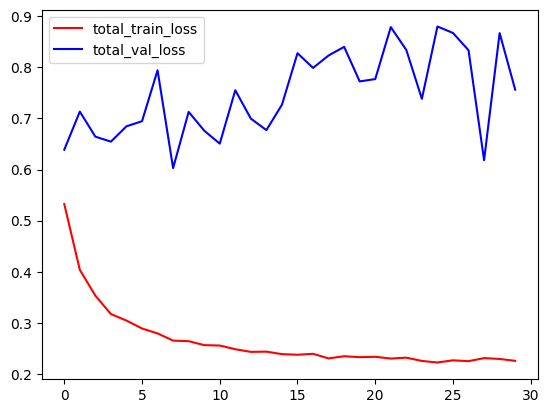

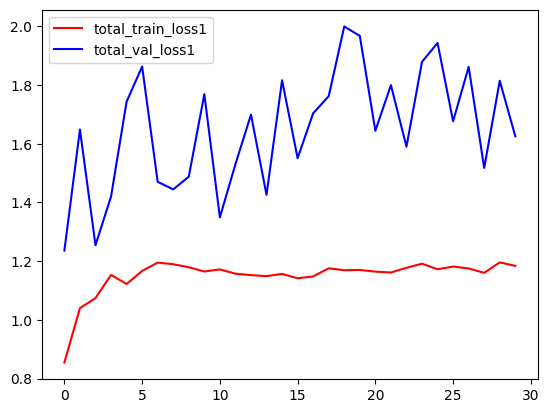

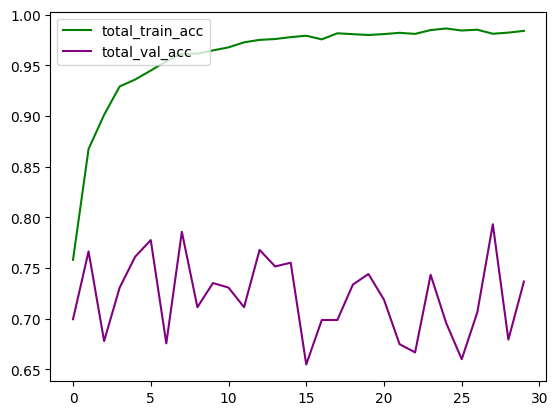

In [39]:
# 绘制折线图
plt.plot(total_train_loss, color='red', label='total_train_loss')
plt.plot(total_val_loss, color='blue', label='total_val_loss')
# 添加图例
plt.legend(loc='upper left')
plt.show()

plt.plot(total_train_loss1, color='red', label='total_train_loss1')
plt.plot(total_val_loss1, color='blue', label='total_val_loss1')
plt.legend(loc='upper left')
plt.show()

plt.plot(total_train_acc, color='green', label='total_train_acc')
plt.plot(total_val_acc, color='purple', label='total_val_acc')
# 添加图例
plt.legend(loc='upper left')
plt.show()

In [40]:
def test_acc(test_loader, model, show=False):
    model.eval()
    test_accs = []
    for batch in test_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        test_accs.append(acc)
    test_acc = sum(test_accs) / len(test_accs)
    if show:
        print("acc of test is ", test_acc.item())
    model.train()
    return test_acc.item()

In [45]:
def predict(folder):
    result = []
    for cur_folder in tqdm(os.listdir(folder)):
        path = os.path.join(folder, cur_folder)
        test_set = DatasetFolder(path, loader=load_image, extensions="jpg", transform=test_tfm)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
        score = test_acc(test_loader, model)
        result.append((int(cur_folder), score))
    df = pd.DataFrame(result, columns=['uuid', 'label'])
    return df


submit = predict('./PETjpg/test1')

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
submit['label'] = submit['label'].apply(lambda x: 'NC' if x <= 0.85 else 'MCI')
submit = submit.sort_values(by='uuid')
submit.to_csv('submit.csv', index=None)